# DCGAN —— Conditional V2
基于NS loss训练出的Conditional GAN，

V2指的是把Match和Real分开来训练。

有一说一这个DCGAN真的太难训练了啊

我使用的Trick
- Soft label
- 数据的均值和标准差不能用实际的值，而是要用0.5 why？

# Import Necessary Packages

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import random

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets
from torchvision import transforms # 张量变换
from torchvision.utils import save_image # 保存图片

from itertools import product # draw 10 * 10 images
from tqdm import tqdm

import matplotlib.pyplot as plt
# Enable Jupyter notebook plotting
%matplotlib inline

# Pytorch Version
print(torch.__version__)
print(torch.cuda.is_available())

1.7.0
True


# Hyper Parameters

In [2]:
cudnn.benchmark = True

#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

batch_size = 128
num_epoch = 100

ngf = 64  # base dimesion of G's feature
ndf = 64 # base dimesion of D's feature
z_dim = 100 # size of input noise's channel
embedding_dim = 10 # size of conditional embedding for both G & D

nc = 3 # channels of output images

lr_G = 3e-4
lr_D = 2e-4 # leanring rate of Generator and Discriminator


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

Random Seed:  8600
cuda:0


# Datasets files & utils

In [3]:
# the path we save data
if not os.path.exists('../../img'):
    os.mkdir('../../img')

# Transform of our datasets
trans = transforms.Compose([transforms.RandomResizedCrop(32, scale=(0.9, 1.0), ratio=(0.9, 1.1), interpolation=2),
                            transforms.RandomHorizontalFlip(p=0.5), # 30% 概率水平翻转
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                            ])
    
# CIFAR10 datasets downloading……
cifar10 = datasets.CIFAR10(
    root = '../../data/cifar10/', train = True, transform = trans, download = True
)

# Dataloader
dataloader = torch.utils.data.DataLoader(
    dataset = cifar10, batch_size = batch_size, shuffle = True, num_workers = 8,
)



Files already downloaded and verified


In [4]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)
# inv_tensor = inv_normalize(tensor)



# Discriminator Definitions (Conditional DCGAN Fashion)
As mentioned, the discriminator, $D$, is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake).

Here, $D$ takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function. 

This architecture can be extended with more layers if necessary for the problem, but there is significance to the use of the strided convolution, BatchNorm, and LeakyReLUs. 
The DCGAN paper mentions it is a good practice to use strided convolution rather than pooling to downsample because it lets the network learn its own pooling function. Also batch norm and leaky relu functions promote healthy gradient flow which is critical for the learning process of both $G$ and $D$.

It is a **conditional** version, it'

In [5]:

class discriminator(nn.Module):
    def __init__(self):
        super(discriminator, self).__init__()
        self.D_conv = nn.Sequential(
            # input is (nc) x 32 x 32
            nn.Conv2d(nc, ndf, kernel_size = 4,
                      stride = 2, padding = 1),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 18
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4 ,ndf * 4, 4, 1, 0, bias=False),
        )
        self.D_embedding = nn.Embedding(num_embeddings = 10, embedding_dim = embedding_dim, ) 
        self.D_match = nn.Sequential(
            nn.Conv2d(ndf * 4 + embedding_dim, ndf , 1, 1, 0, bias=False),
            nn.BatchNorm2d(ndf ),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf , 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.D_real = nn.Sequential(
            nn.Conv2d(ndf * 4 , 1, 1, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x,c):
        x = self.D_conv(x)
        x_c = self.D_embedding(c).view(-1, embedding_dim, 1, 1)
        x_c = torch.cat((x, x_c), 1)
        match = self.D_match(x_c)
        real = self.D_real(x)
        return real,match

# Generator Definitions (Vanilla DCGAN Fashion)
The generator, $G$, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

The generator, G, is designed to map the latent space vector $(z)$ to data-space. Since our data are images, converting z to data-space means ultimately creating a RGB image with the same size as the training images (i.e. 3x64x64). In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. The output of the generator is fed through a tanh function to return it to the input data range of $[−1,1]$. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training. An image of the generator from the DCGAN paper is shown below.

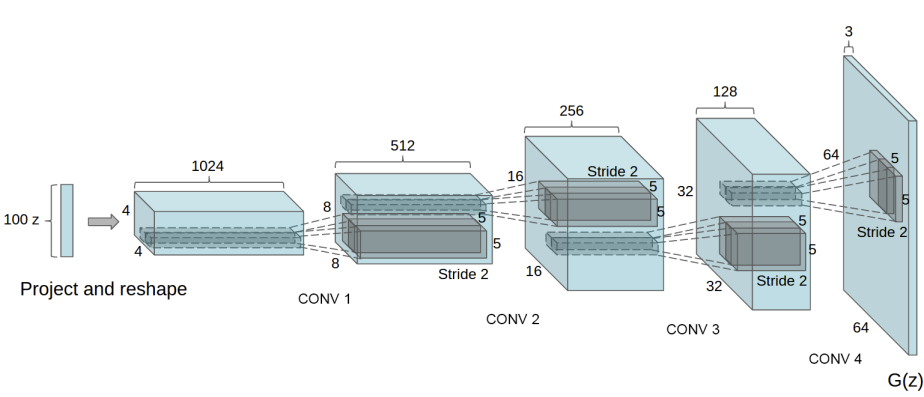

The final `Tanh` activataion function can project output into (-1,1)

Notice, the how the inputs we set in the input section (z_dim, ngf, and nc) influence the generator architecture in code.  is the length of the z input vector, ngf relates to the size of the feature maps that are propagated through the generator, and nc is the number of channels in the output image (set to 3 for RGB images). Below is the code for the generator.


It is a **conditional** version.

In [6]:

class generator(nn.Module):
    
    def __init__(self):
        super(generator, self).__init__()
        self.G = nn.Sequential(
            nn.ConvTranspose2d(z_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4,
                              stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4,
                              stride=2, padding=1, bias=False),
            # state size. nc x 32 x 32            
            nn.Tanh()
            )
        self.G_embedding = nn.Embedding(num_embeddings = 10, embedding_dim = embedding_dim, ) 
        
    def forward(self, x, c):
        x_c = self.G_embedding(c).view(-1, embedding_dim, 1, 1)
        x = torch.cat((x, x_c), 1)
        x = self.G(x)
        return x
        
        

## Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.



In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Traning Phase
## Model & Opitmizer

In [8]:


D = discriminator()
G = generator()
D.apply(weights_init)
G.apply(weights_init)
# TODO: 自定义初始化

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = D.to(device)
G = G.to(device)




In [9]:
criterion = nn.BCELoss() # 二分类交叉熵

d_optimizer = torch.optim.Adam(D.parameters(), lr = lr_D, betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr = lr_G, betas=(0.5,0.999))

## Trainning Start!

In [10]:
G_losses = []
D_losses = []
Miss_real = []
Match_fake = []

for epoch in tqdm(range(num_epoch)):
    for i, (img, condition) in enumerate(dataloader): # Since we don't need any labels, we make label be '_'

        # =============================== IMAGES =================================
        num_img = img.size(0) 
        #img = img.view(num_img, -1) # view()函数作用是将一个多行的Tensor,拼接成一行
                                    # 第一个参数是要拼接的tensor,第二个参数是-1
        # After view(), the input image will be a vector as 28 * 28 = 782 dimensions
        real_img = img.to(device) # the sampled data are real images
        condition = condition.to(device)
        # =============================== LABELS =================================
        real_label = (torch.ones(num_img) - 0.1).view(-1, 1).to(device) # Label of real images is 1
        fake_label = (torch.zeros(num_img) + 0.1).view(-1, 1).to(device) # label of real images is 0
        match_label = torch.ones(num_img).view(-1, 1).to(device)
        miss_label = torch.zeros(num_img).view(-1, 1).to(device)
        # ========================= D: Forward and Loss ==========================
        # Real Image, matched label(contidion)
        real_out,match_out = D(real_img, condition)
        
        d_loss_real = criterion(real_out.view(-1,1), real_label) # TODO: criterion
        d_loss_match = criterion(match_out.view(-1,1), match_label)
        d_loss_real += d_loss_match
        
        # Fake Image, excepted matched label(condition)
        z = torch.randn(num_img, z_dim - embedding_dim, 1, 1).to(device)
        c = torch.randint(low = 0, high = 9, size = (num_img,)).to(device)
        fake_img = G(z, c)
        
        fake_out, _ = D(fake_img, c) # 只需要真假分数
        d_loss_fake = criterion(fake_out.view(-1,1), fake_label)
        
        # Real Image, MISSMATCHED label(condition)
        shuffle = torch.randint(low = 1, high = 9, size = (num_img, ))%9
        shuffle = shuffle.to(device)
        condition_shuffle = (condition + shuffle)%9
        _, miss_out = D(real_img, condition_shuffle) # 只需要匹配分数
        d_loss_miss = criterion(miss_out.view(-1, 1), miss_label)
        
        d_loss = d_loss_real + d_loss_fake + d_loss_miss
        
        d_optimizer.zero_grad() # before back propagation
        d_loss.backward()
        d_optimizer.step()
        
        
        
        # =============== G ========================
        # To fool the Discriminator, we want G's fake output can get 'real' pridection
        z = torch.randn(num_img, z_dim - embedding_dim, 1, 1).to(device)
        c = torch.randint(low = 0, high = 9, size = (num_img,)).to(device)
        # z = torch.randn(num_img, z_dim, 1, 1)
        
        fake_img = G(z, c)
        fake_out, fake_match = D(fake_img, c)
        g_loss = criterion(fake_out.view(-1, 1), real_label)
        g_loss_match = criterion(fake_match.view(-1, 1), match_label)
        g_loss += g_loss_match * (0.5 + 0.01 * epoch) 
        
        real_g_loss = g_loss - g_loss_match * (1 + 0.01 * epoch) + g_loss_match 
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        # ============= Visualization ===============
        D_losses.append(d_loss)
        G_losses.append(real_g_loss)
        Miss_real.append(miss_out.data.mean())
        Match_fake.append(fake_match.data.mean())
        if i%100 == 0:
            print('Epoch[{}/{}],d_loss:{:.4f},g_loss:{:.4f} '
                  'D real: {:.4f},D fake: {:.4f}, D miss:{:.4f}, G match:{:.4f}'.format(
                epoch,num_epoch,d_loss.item(),real_g_loss.item(),
                real_out.data.mean(),fake_out.data.mean(),miss_out.data.mean(),fake_match.data.mean()  #打印的是真实图片的损失均值
            ))
        
    if epoch == 0:
        real_images = inv_normalize(real_img.cpu().data)
        save_image(real_images, '../../img/CV2/real_images.png')
 
    fake_images = inv_normalize(fake_img.cpu().data)
    save_image(fake_images, '../../img/CV2/fake_images-{}.png'.format(epoch+1))

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch[0/100],d_loss:2.8145,g_loss:1.7806 D real: 0.4880,D fake: 0.2129, D miss:0.4995, G match:0.4994
Epoch[0/100],d_loss:2.3821,g_loss:2.0263 D real: 0.6708,D fake: 0.1718, D miss:0.5000, G match:0.4996
Epoch[0/100],d_loss:2.6363,g_loss:2.6050 D real: 0.6277,D fake: 0.0981, D miss:0.5001, G match:0.5003
Epoch[0/100],d_loss:2.7111,g_loss:2.1159 D real: 0.6560,D fake: 0.1706, D miss:0.4991, G match:0.5001


  1%|          | 1/100 [00:29<48:50, 29.60s/it]

Epoch[1/100],d_loss:2.4747,g_loss:2.0350 D real: 0.7004,D fake: 0.1762, D miss:0.4989, G match:0.4984
Epoch[1/100],d_loss:2.3433,g_loss:2.5809 D real: 0.7657,D fake: 0.0935, D miss:0.4973, G match:0.4994
Epoch[1/100],d_loss:2.3287,g_loss:2.6973 D real: 0.7789,D fake: 0.1000, D miss:0.4913, G match:0.4926
Epoch[1/100],d_loss:2.5246,g_loss:1.9503 D real: 0.6714,D fake: 0.1979, D miss:0.4871, G match:0.4878


  2%|▏         | 2/100 [00:54<46:05, 28.22s/it]

Epoch[2/100],d_loss:2.3602,g_loss:1.6368 D real: 0.5894,D fake: 0.2805, D miss:0.4800, G match:0.4716
Epoch[2/100],d_loss:2.4598,g_loss:1.3674 D real: 0.4934,D fake: 0.3834, D miss:0.4548, G match:0.4671
Epoch[2/100],d_loss:2.3105,g_loss:1.8896 D real: 0.6658,D fake: 0.2135, D miss:0.4503, G match:0.4692
Epoch[2/100],d_loss:2.3497,g_loss:2.0771 D real: 0.7451,D fake: 0.1904, D miss:0.4336, G match:0.4396


  3%|▎         | 3/100 [01:19<44:01, 27.23s/it]

Epoch[3/100],d_loss:2.2722,g_loss:1.5719 D real: 0.5100,D fake: 0.3075, D miss:0.4256, G match:0.4705
Epoch[3/100],d_loss:2.3443,g_loss:1.4257 D real: 0.4709,D fake: 0.3555, D miss:0.4108, G match:0.4772
Epoch[3/100],d_loss:2.0095,g_loss:1.7150 D real: 0.5613,D fake: 0.2700, D miss:0.3242, G match:0.4968
Epoch[3/100],d_loss:2.3377,g_loss:1.5463 D real: 0.5819,D fake: 0.2784, D miss:0.3942, G match:0.5604


  4%|▍         | 4/100 [01:51<45:50, 28.65s/it]

Epoch[4/100],d_loss:2.1300,g_loss:1.4416 D real: 0.5586,D fake: 0.3403, D miss:0.3574, G match:0.5196
Epoch[4/100],d_loss:2.1980,g_loss:1.3747 D real: 0.6015,D fake: 0.3382, D miss:0.3663, G match:0.5616
Epoch[4/100],d_loss:2.1421,g_loss:1.8316 D real: 0.7497,D fake: 0.2135, D miss:0.2973, G match:0.5504
Epoch[4/100],d_loss:1.9357,g_loss:1.1076 D real: 0.5126,D fake: 0.4532, D miss:0.2854, G match:0.5924


  5%|▌         | 5/100 [02:18<44:45, 28.26s/it]

Epoch[5/100],d_loss:1.9855,g_loss:1.5018 D real: 0.6406,D fake: 0.3011, D miss:0.3190, G match:0.5583
Epoch[5/100],d_loss:1.9242,g_loss:1.3332 D real: 0.5346,D fake: 0.3615, D miss:0.2426, G match:0.5374
Epoch[5/100],d_loss:1.8934,g_loss:1.4864 D real: 0.5548,D fake: 0.3323, D miss:0.2764, G match:0.5009
Epoch[5/100],d_loss:1.9705,g_loss:1.6771 D real: 0.7399,D fake: 0.2267, D miss:0.2678, G match:0.6530


  6%|▌         | 6/100 [02:41<41:48, 26.68s/it]

Epoch[6/100],d_loss:1.9524,g_loss:1.3726 D real: 0.5973,D fake: 0.3394, D miss:0.2302, G match:0.5648
Epoch[6/100],d_loss:1.7597,g_loss:1.3256 D real: 0.6170,D fake: 0.3424, D miss:0.2222, G match:0.6149
Epoch[6/100],d_loss:1.8551,g_loss:1.4073 D real: 0.5580,D fake: 0.3148, D miss:0.2719, G match:0.6253
Epoch[6/100],d_loss:1.7222,g_loss:1.6898 D real: 0.7055,D fake: 0.2164, D miss:0.2066, G match:0.6448


  7%|▋         | 7/100 [03:07<40:46, 26.30s/it]

Epoch[7/100],d_loss:1.6485,g_loss:1.3551 D real: 0.5974,D fake: 0.3549, D miss:0.2409, G match:0.5524
Epoch[7/100],d_loss:1.6735,g_loss:1.0258 D real: 0.4465,D fake: 0.4573, D miss:0.1916, G match:0.6547
Epoch[7/100],d_loss:1.6567,g_loss:1.1569 D real: 0.5063,D fake: 0.3792, D miss:0.2108, G match:0.6829
Epoch[7/100],d_loss:1.6885,g_loss:1.3304 D real: 0.6819,D fake: 0.3210, D miss:0.1680, G match:0.6697


  8%|▊         | 8/100 [03:36<41:34, 27.12s/it]

Epoch[8/100],d_loss:1.9087,g_loss:0.8901 D real: 0.3151,D fake: 0.5689, D miss:0.1598, G match:0.6189
Epoch[8/100],d_loss:1.5238,g_loss:1.4603 D real: 0.6675,D fake: 0.2840, D miss:0.1845, G match:0.6553
Epoch[8/100],d_loss:1.6354,g_loss:1.4037 D real: 0.6520,D fake: 0.2882, D miss:0.2380, G match:0.6989
Epoch[8/100],d_loss:1.6700,g_loss:1.2756 D real: 0.6968,D fake: 0.3476, D miss:0.1928, G match:0.6559


  9%|▉         | 9/100 [04:05<42:08, 27.79s/it]

Epoch[9/100],d_loss:2.0183,g_loss:1.9957 D real: 0.8385,D fake: 0.1725, D miss:0.1179, G match:0.6024
Epoch[9/100],d_loss:1.7293,g_loss:1.7113 D real: 0.6892,D fake: 0.2282, D miss:0.1187, G match:0.6420
Epoch[9/100],d_loss:1.5026,g_loss:1.3034 D real: 0.6206,D fake: 0.3593, D miss:0.1489, G match:0.6104
Epoch[9/100],d_loss:1.6278,g_loss:1.1319 D real: 0.5316,D fake: 0.4143, D miss:0.1356, G match:0.6468


 10%|█         | 10/100 [04:28<39:34, 26.38s/it]

Epoch[10/100],d_loss:1.7698,g_loss:0.8897 D real: 0.3270,D fake: 0.5808, D miss:0.1040, G match:0.6079
Epoch[10/100],d_loss:1.5697,g_loss:1.5652 D real: 0.7578,D fake: 0.2734, D miss:0.1319, G match:0.5869
Epoch[10/100],d_loss:1.6033,g_loss:1.2673 D real: 0.5489,D fake: 0.3484, D miss:0.1516, G match:0.6609
Epoch[10/100],d_loss:1.3209,g_loss:1.5950 D real: 0.5108,D fake: 0.2748, D miss:0.1381, G match:0.5797


 11%|█         | 11/100 [04:56<39:52, 26.88s/it]

Epoch[11/100],d_loss:1.3989,g_loss:1.3676 D real: 0.4984,D fake: 0.3266, D miss:0.1030, G match:0.6400
Epoch[11/100],d_loss:1.4720,g_loss:1.7424 D real: 0.7115,D fake: 0.2177, D miss:0.0994, G match:0.6273
Epoch[11/100],d_loss:1.6662,g_loss:1.1959 D real: 0.5122,D fake: 0.4114, D miss:0.1326, G match:0.5856
Epoch[11/100],d_loss:1.4253,g_loss:0.8767 D real: 0.4469,D fake: 0.5210, D miss:0.0760, G match:0.7188


 12%|█▏        | 12/100 [05:26<40:34, 27.67s/it]

Epoch[12/100],d_loss:1.4485,g_loss:1.1462 D real: 0.4615,D fake: 0.4574, D miss:0.1002, G match:0.5542
Epoch[12/100],d_loss:1.6132,g_loss:1.1205 D real: 0.4908,D fake: 0.4228, D miss:0.0996, G match:0.6364
Epoch[12/100],d_loss:1.2869,g_loss:1.4596 D real: 0.5777,D fake: 0.3486, D miss:0.0965, G match:0.5256
Epoch[12/100],d_loss:1.5491,g_loss:1.2417 D real: 0.5518,D fake: 0.3687, D miss:0.1256, G match:0.6318


 13%|█▎        | 13/100 [05:51<39:02, 26.92s/it]

Epoch[13/100],d_loss:1.4030,g_loss:1.1952 D real: 0.6070,D fake: 0.4099, D miss:0.0758, G match:0.6228
Epoch[13/100],d_loss:1.4255,g_loss:1.1016 D real: 0.5028,D fake: 0.4689, D miss:0.0943, G match:0.5956
Epoch[13/100],d_loss:1.2659,g_loss:1.4032 D real: 0.5882,D fake: 0.3482, D miss:0.0659, G match:0.5645
Epoch[13/100],d_loss:1.3482,g_loss:1.0872 D real: 0.5375,D fake: 0.4526, D miss:0.0819, G match:0.6256


 14%|█▍        | 14/100 [06:14<37:01, 25.83s/it]

Epoch[14/100],d_loss:1.4143,g_loss:1.8641 D real: 0.7572,D fake: 0.1802, D miss:0.0439, G match:0.6643
Epoch[14/100],d_loss:1.4779,g_loss:1.2442 D real: 0.5718,D fake: 0.4401, D miss:0.0534, G match:0.5371
Epoch[14/100],d_loss:1.7290,g_loss:0.9062 D real: 0.2904,D fake: 0.7793, D miss:0.0550, G match:0.4502
Epoch[14/100],d_loss:1.2802,g_loss:1.7688 D real: 0.7023,D fake: 0.2122, D miss:0.0441, G match:0.6355


 15%|█▌        | 15/100 [06:41<36:58, 26.10s/it]

Epoch[15/100],d_loss:1.1516,g_loss:1.3250 D real: 0.5675,D fake: 0.4238, D miss:0.0455, G match:0.5227
Epoch[15/100],d_loss:1.4486,g_loss:1.4330 D real: 0.5516,D fake: 0.4110, D miss:0.0667, G match:0.4756
Epoch[15/100],d_loss:1.4673,g_loss:0.8058 D real: 0.3701,D fake: 0.6840, D miss:0.0433, G match:0.5818
Epoch[15/100],d_loss:2.7560,g_loss:1.1062 D real: 0.5091,D fake: 0.4804, D miss:0.4933, G match:0.4861


 16%|█▌        | 16/100 [07:08<36:44, 26.25s/it]

Epoch[16/100],d_loss:2.1731,g_loss:1.1224 D real: 0.5382,D fake: 0.4576, D miss:0.3200, G match:0.5409
Epoch[16/100],d_loss:1.5482,g_loss:1.0685 D real: 0.5792,D fake: 0.5031, D miss:0.1085, G match:0.5829
Epoch[16/100],d_loss:1.4293,g_loss:1.8808 D real: 0.7072,D fake: 0.1797, D miss:0.0848, G match:0.6614
Epoch[16/100],d_loss:1.4661,g_loss:1.0226 D real: 0.4318,D fake: 0.4690, D miss:0.0564, G match:0.6282


 17%|█▋        | 17/100 [07:32<35:41, 25.80s/it]

Epoch[17/100],d_loss:1.4480,g_loss:0.7354 D real: 0.4226,D fake: 0.6141, D miss:0.0541, G match:0.7092
Epoch[17/100],d_loss:1.3723,g_loss:1.0632 D real: 0.5257,D fake: 0.4231, D miss:0.0378, G match:0.6922
Epoch[17/100],d_loss:1.4371,g_loss:1.5223 D real: 0.6047,D fake: 0.2997, D miss:0.1068, G match:0.5825
Epoch[17/100],d_loss:1.3129,g_loss:1.0100 D real: 0.4610,D fake: 0.4880, D miss:0.0380, G match:0.6212


 18%|█▊        | 18/100 [07:57<34:56, 25.56s/it]

Epoch[18/100],d_loss:1.5848,g_loss:1.5737 D real: 0.7424,D fake: 0.2726, D miss:0.0478, G match:0.5789
Epoch[18/100],d_loss:1.3363,g_loss:1.1172 D real: 0.4886,D fake: 0.3891, D miss:0.0502, G match:0.7272
Epoch[18/100],d_loss:1.3597,g_loss:1.3287 D real: 0.5754,D fake: 0.3523, D miss:0.0680, G match:0.5797
Epoch[18/100],d_loss:1.4732,g_loss:1.1117 D real: 0.5403,D fake: 0.4435, D miss:0.0449, G match:0.6245


 19%|█▉        | 19/100 [08:25<35:24, 26.23s/it]

Epoch[19/100],d_loss:1.5171,g_loss:0.8538 D real: 0.3822,D fake: 0.5683, D miss:0.0451, G match:0.6487
Epoch[19/100],d_loss:1.3502,g_loss:1.1516 D real: 0.6062,D fake: 0.3904, D miss:0.0443, G match:0.6824
Epoch[19/100],d_loss:1.3773,g_loss:0.9839 D real: 0.4342,D fake: 0.5539, D miss:0.0460, G match:0.5764
Epoch[19/100],d_loss:1.3593,g_loss:1.5670 D real: 0.6292,D fake: 0.2802, D miss:0.0434, G match:0.5906


 20%|██        | 20/100 [08:55<36:20, 27.26s/it]

Epoch[20/100],d_loss:1.3637,g_loss:1.7382 D real: 0.6068,D fake: 0.1996, D miss:0.0289, G match:0.7417
Epoch[20/100],d_loss:1.6158,g_loss:0.8801 D real: 0.3333,D fake: 0.5556, D miss:0.0539, G match:0.6682
Epoch[20/100],d_loss:1.2738,g_loss:1.7332 D real: 0.6756,D fake: 0.2276, D miss:0.0259, G match:0.5983
Epoch[20/100],d_loss:1.3022,g_loss:1.4941 D real: 0.7248,D fake: 0.2733, D miss:0.0349, G match:0.6806


 21%|██        | 21/100 [09:18<34:23, 26.12s/it]

Epoch[21/100],d_loss:1.3438,g_loss:1.1259 D real: 0.6188,D fake: 0.4398, D miss:0.0259, G match:0.6073
Epoch[21/100],d_loss:1.3281,g_loss:1.3107 D real: 0.6042,D fake: 0.3507, D miss:0.0310, G match:0.6410
Epoch[21/100],d_loss:1.3241,g_loss:1.4934 D real: 0.6586,D fake: 0.2606, D miss:0.0563, G match:0.7149
Epoch[21/100],d_loss:1.5190,g_loss:1.3447 D real: 0.4977,D fake: 0.3407, D miss:0.0431, G match:0.6267


 22%|██▏       | 22/100 [09:48<35:11, 27.07s/it]

Epoch[22/100],d_loss:1.4342,g_loss:1.8359 D real: 0.7328,D fake: 0.2078, D miss:0.0307, G match:0.5929
Epoch[22/100],d_loss:1.2402,g_loss:1.3959 D real: 0.6298,D fake: 0.3640, D miss:0.0297, G match:0.5360
Epoch[22/100],d_loss:1.3756,g_loss:1.2438 D real: 0.4551,D fake: 0.3866, D miss:0.0263, G match:0.6091
Epoch[22/100],d_loss:1.2788,g_loss:1.0879 D real: 0.5789,D fake: 0.4216, D miss:0.0373, G match:0.6769


 23%|██▎       | 23/100 [10:14<34:33, 26.93s/it]

Epoch[23/100],d_loss:1.3461,g_loss:1.1178 D real: 0.4314,D fake: 0.4958, D miss:0.0318, G match:0.5241
Epoch[23/100],d_loss:1.3215,g_loss:1.6072 D real: 0.6337,D fake: 0.2909, D miss:0.0228, G match:0.5249
Epoch[23/100],d_loss:1.2396,g_loss:1.5279 D real: 0.5854,D fake: 0.2802, D miss:0.0236, G match:0.6068
Epoch[23/100],d_loss:1.3399,g_loss:1.1766 D real: 0.4815,D fake: 0.4324, D miss:0.0303, G match:0.5851


 24%|██▍       | 24/100 [10:41<33:57, 26.80s/it]

Epoch[24/100],d_loss:1.3791,g_loss:1.5241 D real: 0.6406,D fake: 0.3075, D miss:0.0168, G match:0.5733
Epoch[24/100],d_loss:1.2185,g_loss:1.2942 D real: 0.5782,D fake: 0.3268, D miss:0.0332, G match:0.7065
Epoch[24/100],d_loss:1.3353,g_loss:1.1510 D real: 0.4440,D fake: 0.4140, D miss:0.0174, G match:0.6356
Epoch[24/100],d_loss:1.3381,g_loss:1.2693 D real: 0.6982,D fake: 0.3493, D miss:0.0148, G match:0.6672


 25%|██▌       | 25/100 [11:09<34:06, 27.28s/it]

Epoch[25/100],d_loss:2.8933,g_loss:0.9545 D real: 0.4950,D fake: 0.4939, D miss:0.4747, G match:0.6506
Epoch[25/100],d_loss:2.6086,g_loss:0.9701 D real: 0.5257,D fake: 0.4648, D miss:0.4489, G match:0.6829
Epoch[25/100],d_loss:2.6473,g_loss:1.0378 D real: 0.5654,D fake: 0.4411, D miss:0.4245, G match:0.6578
Epoch[25/100],d_loss:1.9039,g_loss:1.0074 D real: 0.5074,D fake: 0.4641, D miss:0.2720, G match:0.6798


 26%|██▌       | 26/100 [11:30<31:08, 25.25s/it]

Epoch[26/100],d_loss:1.4360,g_loss:1.0523 D real: 0.5587,D fake: 0.4404, D miss:0.0860, G match:0.6875
Epoch[26/100],d_loss:1.2425,g_loss:1.1094 D real: 0.6265,D fake: 0.3874, D miss:0.0360, G match:0.7447
Epoch[26/100],d_loss:1.2068,g_loss:1.2176 D real: 0.5513,D fake: 0.3525, D miss:0.0190, G match:0.7038
Epoch[26/100],d_loss:1.4370,g_loss:1.2555 D real: 0.6713,D fake: 0.3530, D miss:0.0238, G match:0.6573


 27%|██▋       | 27/100 [11:58<32:02, 26.34s/it]

Epoch[27/100],d_loss:1.5015,g_loss:0.9257 D real: 0.3872,D fake: 0.5826, D miss:0.0210, G match:0.5977
Epoch[27/100],d_loss:1.2556,g_loss:1.6905 D real: 0.6901,D fake: 0.2569, D miss:0.0236, G match:0.5757
Epoch[27/100],d_loss:1.4286,g_loss:1.3671 D real: 0.5973,D fake: 0.3158, D miss:0.0143, G match:0.6592
Epoch[27/100],d_loss:1.1657,g_loss:1.2856 D real: 0.5590,D fake: 0.3084, D miss:0.0235, G match:0.7856


 28%|██▊       | 28/100 [12:23<30:51, 25.72s/it]

Epoch[28/100],d_loss:1.2971,g_loss:1.0638 D real: 0.5200,D fake: 0.4607, D miss:0.0242, G match:0.6233
Epoch[28/100],d_loss:1.3628,g_loss:1.5962 D real: 0.6449,D fake: 0.2388, D miss:0.0310, G match:0.7150
Epoch[28/100],d_loss:1.5148,g_loss:1.7518 D real: 0.7017,D fake: 0.2267, D miss:0.0191, G match:0.6116
Epoch[28/100],d_loss:1.2852,g_loss:1.0222 D real: 0.4341,D fake: 0.4591, D miss:0.0223, G match:0.6834


 29%|██▉       | 29/100 [12:48<30:19, 25.63s/it]

Epoch[29/100],d_loss:1.1817,g_loss:1.3998 D real: 0.5822,D fake: 0.3350, D miss:0.0191, G match:0.5851
Epoch[29/100],d_loss:1.4951,g_loss:1.9676 D real: 0.7170,D fake: 0.1779, D miss:0.0228, G match:0.6267
Epoch[29/100],d_loss:1.1893,g_loss:1.1205 D real: 0.5656,D fake: 0.4112, D miss:0.0159, G match:0.6737
Epoch[29/100],d_loss:1.3947,g_loss:0.9090 D real: 0.4022,D fake: 0.5219, D miss:0.0255, G match:0.6821


 30%|███       | 30/100 [13:14<29:51, 25.59s/it]

Epoch[30/100],d_loss:1.3184,g_loss:1.4095 D real: 0.7151,D fake: 0.2906, D miss:0.0212, G match:0.7105
Epoch[30/100],d_loss:1.2652,g_loss:1.3575 D real: 0.6074,D fake: 0.3253, D miss:0.0174, G match:0.6716
Epoch[30/100],d_loss:1.2332,g_loss:1.2614 D real: 0.5724,D fake: 0.4377, D miss:0.0275, G match:0.5419
Epoch[30/100],d_loss:1.3509,g_loss:1.7293 D real: 0.7477,D fake: 0.2337, D miss:0.0164, G match:0.5899


 31%|███       | 31/100 [13:41<29:58, 26.06s/it]

Epoch[31/100],d_loss:1.1970,g_loss:1.1982 D real: 0.5135,D fake: 0.3932, D miss:0.0114, G match:0.6578
Epoch[31/100],d_loss:1.2352,g_loss:1.5158 D real: 0.5685,D fake: 0.3174, D miss:0.0139, G match:0.5541
Epoch[31/100],d_loss:1.1422,g_loss:1.3782 D real: 0.6601,D fake: 0.3524, D miss:0.0115, G match:0.5711
Epoch[31/100],d_loss:14.6774,g_loss:1.8799 D real: 0.6742,D fake: 0.5133, D miss:0.4396, G match:0.4460


 32%|███▏      | 32/100 [14:09<30:19, 26.75s/it]

Epoch[32/100],d_loss:1.4388,g_loss:1.0678 D real: 0.5890,D fake: 0.4289, D miss:0.0513, G match:0.6949
Epoch[32/100],d_loss:1.4331,g_loss:1.0145 D real: 0.4759,D fake: 0.5336, D miss:0.0250, G match:0.5780
Epoch[32/100],d_loss:1.1166,g_loss:1.5509 D real: 0.6826,D fake: 0.2430, D miss:0.0140, G match:0.7237
Epoch[32/100],d_loss:1.4086,g_loss:1.1502 D real: 0.4093,D fake: 0.3991, D miss:0.0232, G match:0.6878


 33%|███▎      | 33/100 [14:39<30:59, 27.76s/it]

Epoch[33/100],d_loss:1.1777,g_loss:1.3840 D real: 0.6031,D fake: 0.3369, D miss:0.0110, G match:0.5980
Epoch[33/100],d_loss:1.1651,g_loss:1.4810 D real: 0.5983,D fake: 0.3380, D miss:0.0181, G match:0.5389
Epoch[33/100],d_loss:1.2549,g_loss:1.1961 D real: 0.5947,D fake: 0.4239, D miss:0.0148, G match:0.5984
Epoch[33/100],d_loss:1.1531,g_loss:1.4448 D real: 0.6048,D fake: 0.3134, D miss:0.0188, G match:0.6083


 34%|███▍      | 34/100 [15:06<30:03, 27.33s/it]

Epoch[34/100],d_loss:1.2785,g_loss:1.6308 D real: 0.6704,D fake: 0.2800, D miss:0.0145, G match:0.5724
Epoch[34/100],d_loss:1.1841,g_loss:1.4532 D real: 0.5777,D fake: 0.3294, D miss:0.0094, G match:0.5738
Epoch[34/100],d_loss:1.2968,g_loss:1.6360 D real: 0.7344,D fake: 0.2941, D miss:0.0223, G match:0.5012
Epoch[34/100],d_loss:1.2720,g_loss:1.2889 D real: 0.6478,D fake: 0.4223, D miss:0.0107, G match:0.5476


 35%|███▌      | 35/100 [15:36<30:38, 28.29s/it]

Epoch[35/100],d_loss:1.3603,g_loss:0.8451 D real: 0.4200,D fake: 0.5799, D miss:0.0144, G match:0.6707
Epoch[35/100],d_loss:1.0946,g_loss:1.3198 D real: 0.6185,D fake: 0.3718, D miss:0.0082, G match:0.5767
Epoch[35/100],d_loss:1.1958,g_loss:1.2363 D real: 0.6415,D fake: 0.3936, D miss:0.0131, G match:0.6299
Epoch[35/100],d_loss:1.2392,g_loss:1.3651 D real: 0.6780,D fake: 0.3627, D miss:0.0129, G match:0.5656


 36%|███▌      | 36/100 [16:00<28:52, 27.07s/it]

Epoch[36/100],d_loss:1.2488,g_loss:1.5724 D real: 0.6018,D fake: 0.2731, D miss:0.0263, G match:0.6034
Epoch[36/100],d_loss:1.3137,g_loss:1.1583 D real: 0.4224,D fake: 0.5101, D miss:0.0085, G match:0.5045
Epoch[36/100],d_loss:1.2362,g_loss:1.7034 D real: 0.6179,D fake: 0.2643, D miss:0.0177, G match:0.5557
Epoch[36/100],d_loss:2.5437,g_loss:1.4104 D real: 0.5471,D fake: 0.3638, D miss:0.3362, G match:0.4891


 37%|███▋      | 37/100 [16:26<27:56, 26.61s/it]

Epoch[37/100],d_loss:1.5943,g_loss:0.9581 D real: 0.5440,D fake: 0.4825, D miss:0.1730, G match:0.6999
Epoch[37/100],d_loss:1.4353,g_loss:1.0387 D real: 0.4719,D fake: 0.4440, D miss:0.0358, G match:0.6957
Epoch[37/100],d_loss:1.2082,g_loss:1.7175 D real: 0.6969,D fake: 0.2168, D miss:0.0185, G match:0.6724
Epoch[37/100],d_loss:1.2616,g_loss:1.3163 D real: 0.5798,D fake: 0.3542, D miss:0.0188, G match:0.6220


 38%|███▊      | 38/100 [17:00<29:43, 28.77s/it]

Epoch[38/100],d_loss:1.0871,g_loss:1.1142 D real: 0.6150,D fake: 0.4173, D miss:0.0228, G match:0.6563
Epoch[38/100],d_loss:1.2504,g_loss:1.0709 D real: 0.5347,D fake: 0.4261, D miss:0.0134, G match:0.7218
Epoch[38/100],d_loss:1.3653,g_loss:0.9358 D real: 0.4294,D fake: 0.5317, D miss:0.0120, G match:0.6469
Epoch[38/100],d_loss:1.2204,g_loss:1.5790 D real: 0.7060,D fake: 0.2818, D miss:0.0120, G match:0.5815


 39%|███▉      | 39/100 [17:27<28:40, 28.20s/it]

Epoch[39/100],d_loss:1.2561,g_loss:1.3096 D real: 0.4317,D fake: 0.4114, D miss:0.0135, G match:0.5299
Epoch[39/100],d_loss:1.3125,g_loss:0.9134 D real: 0.4563,D fake: 0.5734, D miss:0.0098, G match:0.5993
Epoch[39/100],d_loss:1.3073,g_loss:1.4721 D real: 0.6485,D fake: 0.3082, D miss:0.0216, G match:0.6138
Epoch[39/100],d_loss:1.1635,g_loss:1.3511 D real: 0.6363,D fake: 0.3308, D miss:0.0171, G match:0.6542


 40%|████      | 40/100 [17:56<28:26, 28.44s/it]

Epoch[40/100],d_loss:1.2190,g_loss:1.5611 D real: 0.6714,D fake: 0.2990, D miss:0.0139, G match:0.5731
Epoch[40/100],d_loss:1.1653,g_loss:1.2236 D real: 0.4993,D fake: 0.3881, D miss:0.0161, G match:0.6486
Epoch[40/100],d_loss:1.2259,g_loss:1.2095 D real: 0.5446,D fake: 0.3928, D miss:0.0198, G match:0.7125
Epoch[40/100],d_loss:1.2414,g_loss:1.2242 D real: 0.6725,D fake: 0.3671, D miss:0.0218, G match:0.6848


 41%|████      | 41/100 [18:24<27:50, 28.32s/it]

Epoch[41/100],d_loss:1.1570,g_loss:1.4055 D real: 0.6061,D fake: 0.3374, D miss:0.0073, G match:0.6128
Epoch[41/100],d_loss:1.3864,g_loss:1.9143 D real: 0.8302,D fake: 0.1956, D miss:0.0120, G match:0.6065
Epoch[41/100],d_loss:1.1404,g_loss:1.5503 D real: 0.6321,D fake: 0.2812, D miss:0.0086, G match:0.6330
Epoch[41/100],d_loss:1.3438,g_loss:1.7599 D real: 0.7262,D fake: 0.2764, D miss:0.0252, G match:0.4680


 42%|████▏     | 42/100 [18:52<27:31, 28.47s/it]

Epoch[42/100],d_loss:1.2383,g_loss:1.1492 D real: 0.4902,D fake: 0.4637, D miss:0.0104, G match:0.5825
Epoch[42/100],d_loss:1.1072,g_loss:1.4454 D real: 0.7186,D fake: 0.3318, D miss:0.0146, G match:0.6032
Epoch[42/100],d_loss:1.1717,g_loss:1.6924 D real: 0.6407,D fake: 0.3013, D miss:0.0077, G match:0.4665
Epoch[42/100],d_loss:1.1068,g_loss:1.4940 D real: 0.6576,D fake: 0.3118, D miss:0.0080, G match:0.6292


 43%|████▎     | 43/100 [19:19<26:37, 28.02s/it]

Epoch[43/100],d_loss:1.0504,g_loss:1.3093 D real: 0.6385,D fake: 0.3685, D miss:0.0103, G match:0.6155
Epoch[43/100],d_loss:1.1046,g_loss:1.1758 D real: 0.5865,D fake: 0.4140, D miss:0.0073, G match:0.6371
Epoch[43/100],d_loss:1.2412,g_loss:1.8927 D real: 0.7543,D fake: 0.2186, D miss:0.0090, G match:0.5753
Epoch[43/100],d_loss:1.1631,g_loss:1.2423 D real: 0.5378,D fake: 0.4028, D miss:0.0056, G match:0.5961


 44%|████▍     | 44/100 [19:48<26:25, 28.30s/it]

Epoch[44/100],d_loss:1.0089,g_loss:1.4669 D real: 0.5984,D fake: 0.3190, D miss:0.0089, G match:0.6040
Epoch[44/100],d_loss:1.2590,g_loss:1.0339 D real: 0.5047,D fake: 0.4958, D miss:0.0134, G match:0.6111
Epoch[44/100],d_loss:1.1968,g_loss:1.2706 D real: 0.6290,D fake: 0.3855, D miss:0.0081, G match:0.6362
Epoch[44/100],d_loss:1.0558,g_loss:1.5192 D real: 0.6148,D fake: 0.2890, D miss:0.0215, G match:0.6374


 45%|████▌     | 45/100 [20:20<26:46, 29.22s/it]

Epoch[45/100],d_loss:1.1818,g_loss:1.8004 D real: 0.7027,D fake: 0.2602, D miss:0.0055, G match:0.4692
Epoch[45/100],d_loss:1.1915,g_loss:1.2352 D real: 0.5229,D fake: 0.4410, D miss:0.0114, G match:0.5709
Epoch[45/100],d_loss:1.3216,g_loss:1.1213 D real: 0.4415,D fake: 0.4726, D miss:0.0102, G match:0.6016
Epoch[45/100],d_loss:1.1957,g_loss:1.6484 D real: 0.5884,D fake: 0.3239, D miss:0.0048, G match:0.4895


 46%|████▌     | 46/100 [20:49<26:24, 29.34s/it]

Epoch[46/100],d_loss:1.0240,g_loss:1.6663 D real: 0.6639,D fake: 0.2693, D miss:0.0130, G match:0.5692
Epoch[46/100],d_loss:1.0559,g_loss:1.6953 D real: 0.7062,D fake: 0.2305, D miss:0.0056, G match:0.6449
Epoch[46/100],d_loss:1.7618,g_loss:1.5193 D real: 0.5848,D fake: 0.3953, D miss:0.2898, G match:0.4643
Epoch[46/100],d_loss:0.9991,g_loss:2.4791 D real: 0.7533,D fake: 0.1212, D miss:0.0813, G match:0.5505


 47%|████▋     | 47/100 [21:19<26:08, 29.59s/it]

Epoch[47/100],d_loss:1.1841,g_loss:1.5717 D real: 0.7020,D fake: 0.3240, D miss:0.1016, G match:0.5615
Epoch[47/100],d_loss:1.0940,g_loss:1.8206 D real: 0.6978,D fake: 0.2082, D miss:0.0322, G match:0.6498
Epoch[47/100],d_loss:1.1395,g_loss:2.0037 D real: 0.8218,D fake: 0.1657, D miss:0.0265, G match:0.6885
Epoch[47/100],d_loss:1.0489,g_loss:1.6313 D real: 0.7543,D fake: 0.2388, D miss:0.0204, G match:0.6978


 48%|████▊     | 48/100 [21:45<24:32, 28.31s/it]

Epoch[48/100],d_loss:1.1201,g_loss:1.7039 D real: 0.7689,D fake: 0.2327, D miss:0.0193, G match:0.6655
Epoch[48/100],d_loss:1.1548,g_loss:1.2183 D real: 0.6753,D fake: 0.4128, D miss:0.0327, G match:0.6499
Epoch[48/100],d_loss:1.1047,g_loss:1.3255 D real: 0.7376,D fake: 0.3583, D miss:0.0297, G match:0.6592
Epoch[48/100],d_loss:1.2701,g_loss:1.5823 D real: 0.7635,D fake: 0.2853, D miss:0.0188, G match:0.6454


 49%|████▉     | 49/100 [22:11<23:34, 27.73s/it]

Epoch[49/100],d_loss:1.2529,g_loss:1.7799 D real: 0.8327,D fake: 0.2364, D miss:0.0130, G match:0.6416
Epoch[49/100],d_loss:1.3756,g_loss:0.7983 D real: 0.3958,D fake: 0.7335, D miss:0.0154, G match:0.5854
Epoch[49/100],d_loss:0.9886,g_loss:1.4179 D real: 0.6616,D fake: 0.3078, D miss:0.0133, G match:0.6596
Epoch[49/100],d_loss:1.1721,g_loss:1.4175 D real: 0.5122,D fake: 0.3104, D miss:0.0099, G match:0.6842


 50%|█████     | 50/100 [22:39<23:09, 27.80s/it]

Epoch[50/100],d_loss:1.1366,g_loss:1.5419 D real: 0.7392,D fake: 0.2717, D miss:0.0099, G match:0.7151
Epoch[50/100],d_loss:1.7522,g_loss:2.3735 D real: 0.7416,D fake: 0.1188, D miss:0.0168, G match:0.6847
Epoch[50/100],d_loss:1.2429,g_loss:1.4162 D real: 0.6220,D fake: 0.3465, D miss:0.0115, G match:0.6337
Epoch[50/100],d_loss:1.2375,g_loss:1.3159 D real: 0.5444,D fake: 0.3957, D miss:0.0097, G match:0.5648


 51%|█████     | 51/100 [23:10<23:28, 28.74s/it]

Epoch[51/100],d_loss:1.2538,g_loss:1.6659 D real: 0.7045,D fake: 0.2498, D miss:0.0137, G match:0.6374
Epoch[51/100],d_loss:0.9338,g_loss:1.4358 D real: 0.6477,D fake: 0.3062, D miss:0.0090, G match:0.6619
Epoch[51/100],d_loss:1.1024,g_loss:1.3851 D real: 0.6198,D fake: 0.3458, D miss:0.0100, G match:0.6353
Epoch[51/100],d_loss:0.9979,g_loss:1.6099 D real: 0.7669,D fake: 0.2706, D miss:0.0126, G match:0.6339


 52%|█████▏    | 52/100 [23:32<21:26, 26.81s/it]

Epoch[52/100],d_loss:0.9567,g_loss:1.3491 D real: 0.6789,D fake: 0.3366, D miss:0.0076, G match:0.6867
Epoch[52/100],d_loss:1.0096,g_loss:1.8610 D real: 0.7719,D fake: 0.2139, D miss:0.0094, G match:0.6518
Epoch[52/100],d_loss:1.3096,g_loss:2.1658 D real: 0.8672,D fake: 0.1409, D miss:0.0062, G match:0.7071
Epoch[52/100],d_loss:1.1295,g_loss:1.2709 D real: 0.5649,D fake: 0.3909, D miss:0.0109, G match:0.6138


 53%|█████▎    | 53/100 [24:04<22:06, 28.22s/it]

Epoch[53/100],d_loss:1.1805,g_loss:1.3734 D real: 0.6175,D fake: 0.3414, D miss:0.0096, G match:0.7210
Epoch[53/100],d_loss:1.3035,g_loss:1.2714 D real: 0.5403,D fake: 0.3791, D miss:0.0052, G match:0.6819
Epoch[53/100],d_loss:1.1261,g_loss:1.7757 D real: 0.6660,D fake: 0.2268, D miss:0.0049, G match:0.5941
Epoch[53/100],d_loss:1.5860,g_loss:2.1183 D real: 0.8858,D fake: 0.1520, D miss:0.0069, G match:0.6230


 54%|█████▍    | 54/100 [24:28<20:48, 27.14s/it]

Epoch[54/100],d_loss:1.4377,g_loss:0.9695 D real: 0.3529,D fake: 0.6473, D miss:0.0050, G match:0.4885
Epoch[54/100],d_loss:1.9737,g_loss:0.6932 D real: 0.2197,D fake: 0.7337, D miss:0.0049, G match:0.6463
Epoch[54/100],d_loss:1.4521,g_loss:2.5952 D real: 0.8446,D fake: 0.0959, D miss:0.0040, G match:0.6165
Epoch[54/100],d_loss:1.2175,g_loss:1.0650 D real: 0.4743,D fake: 0.5290, D miss:0.0055, G match:0.5589


 55%|█████▌    | 55/100 [24:53<19:51, 26.47s/it]

Epoch[55/100],d_loss:1.1148,g_loss:1.4020 D real: 0.5461,D fake: 0.3762, D miss:0.0059, G match:0.5412
Epoch[55/100],d_loss:1.0215,g_loss:1.4631 D real: 0.5976,D fake: 0.3179, D miss:0.0029, G match:0.6282
Epoch[55/100],d_loss:1.1103,g_loss:1.4187 D real: 0.7591,D fake: 0.3575, D miss:0.0071, G match:0.5452
Epoch[55/100],d_loss:1.3158,g_loss:1.6378 D real: 0.7311,D fake: 0.2711, D miss:0.0046, G match:0.6304


 56%|█████▌    | 56/100 [25:19<19:08, 26.10s/it]

Epoch[56/100],d_loss:1.0950,g_loss:1.2273 D real: 0.6252,D fake: 0.3937, D miss:0.0074, G match:0.6657
Epoch[56/100],d_loss:0.9512,g_loss:1.7000 D real: 0.6891,D fake: 0.2487, D miss:0.0033, G match:0.6876
Epoch[56/100],d_loss:1.1718,g_loss:1.5379 D real: 0.6044,D fake: 0.2911, D miss:0.0030, G match:0.6591


 56%|█████▌    | 56/100 [25:37<20:07, 27.45s/it]


KeyboardInterrupt: 

# Visualization
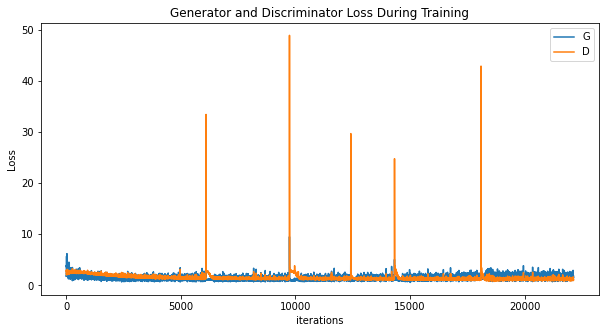

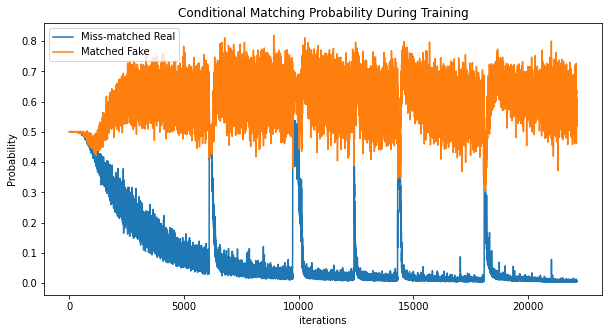

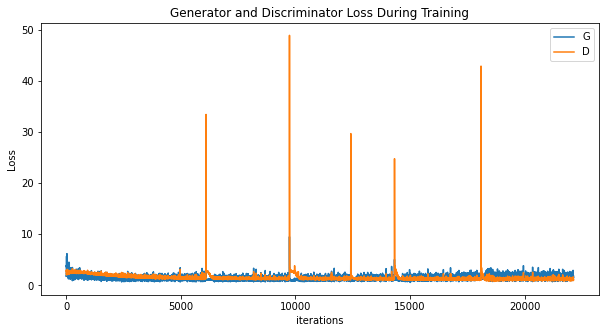

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

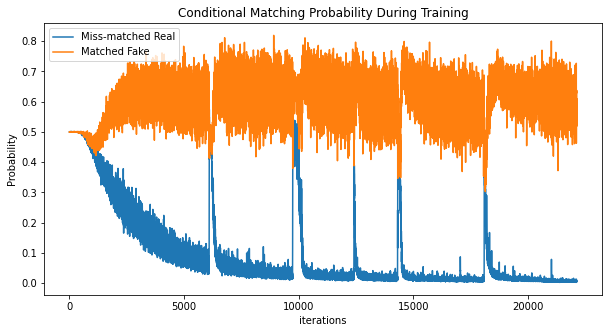

In [12]:
plt.figure(figsize=(10,5))
plt.title("Conditional Matching Probability During Training")
plt.plot(Miss_real,label="Miss-matched Real")
plt.plot(Match_fake,label="Matched Fake")
plt.xlabel("iterations")
plt.ylabel("Probability")
plt.legend()
plt.show()

In [13]:
if not os.path.exists('../../img/CV2/conditional'):
    os.mkdir('../../img/CV2/conditional')

for i in range(10):
    c = torch.randint(low = 0, high = 9, size = (num_img,)).to(device)
    c = c * 0 + i
    z = torch.randn(num_img, z_dim - embedding_dim, 1, 1).to(device)
    conditional_img = G(z, c)    
    conditional_img = inv_normalize(conditional_img.cpu().data)
    save_image(conditional_img, '../../img/CV2/conditional/Condtional_fake_images-{}.png'.format(i))

# 可视化结论
## 1. 飞机
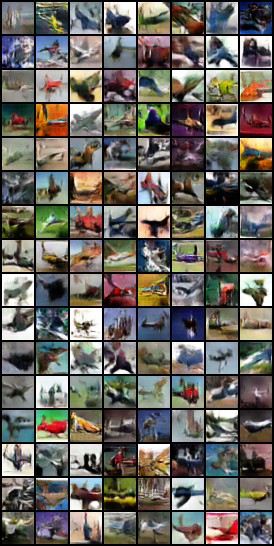
## 2. 小汽车
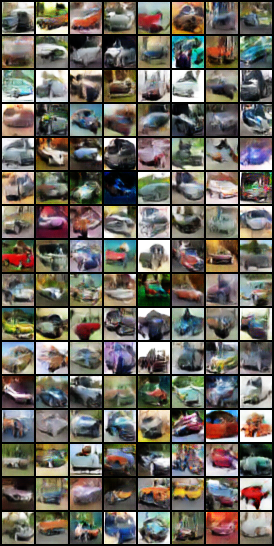
## 3. 鸟
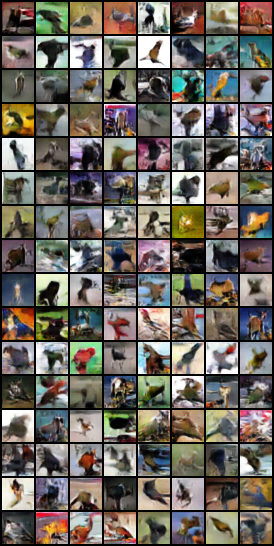
## 4. 猫
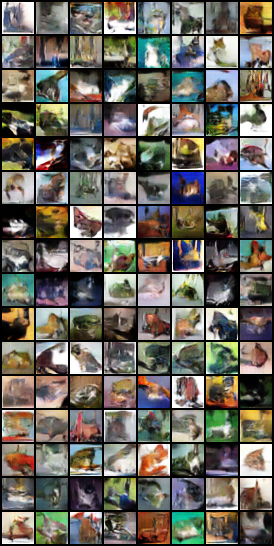
## 5. 鹿
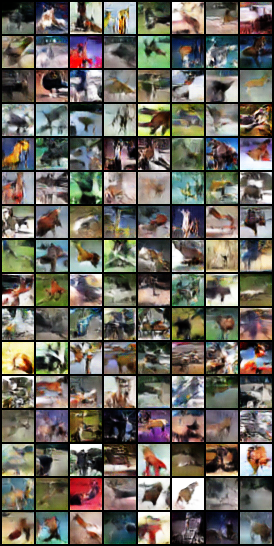
## 6. 狗
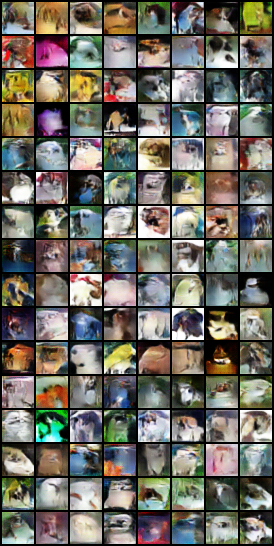
## 7. 青蛙
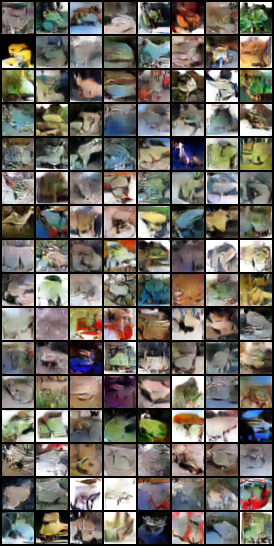
## 8. 马
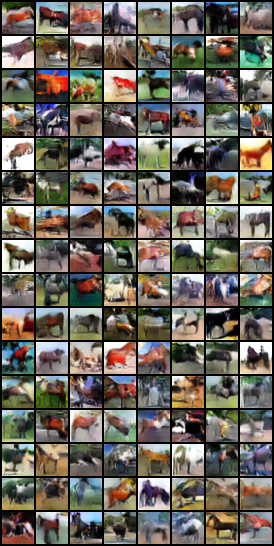
## 9. 船
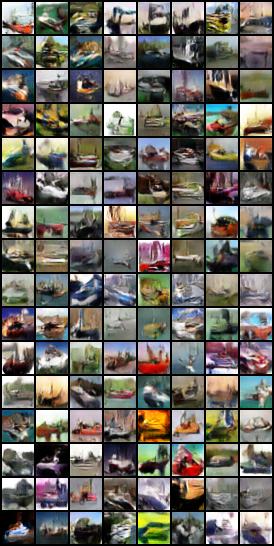
## 10. 卡车
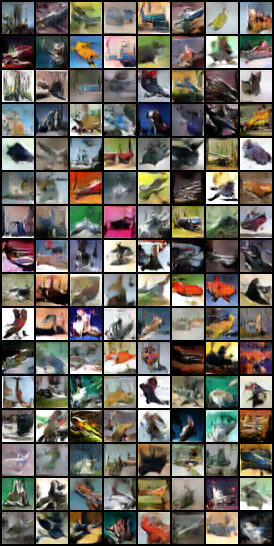

### 一个Idea
可以看出，每个conditional输出的图片其实都会很奇怪，有可能是因为有些重要的信息（比如背景颜色）被编码在了输入的外面，所以
**是否可以借鉴VAE的方法，由Generator自行输出剩余部分变量的统计范围？**
# 保存一下网络


In [ ]:
for i in range(10):
    c = torch.randint(low = 0, high = 9, size = (num_img,)).to(device)
    c = c * 0 + i
    print(c)